# Mount drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [ ]:
!pip install discopy==1.1.4
!pip install lambeq

# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, TensorAnsatz, SpiderAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
S = AtomicType.SENTENCE
N = AtomicType.NOUN
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import PytorchModel, PytorchTrainer, Dataset, CrossEntropyLoss
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [ ]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [ ]:
def create_multi_diagrams(df, reader):
    diagrams, targets = [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "US":
            targets.append([1.0, 0.0, 0.0, 0.0])
        elif target == "SE":
            targets.append([0.0, 1.0, 0.0, 0.0])
        elif target == "O":
            targets.append([0.0, 0.0, 1.0, 0.0])
        elif target == "PE":
            targets.append([0.0, 0.0, 0.0, 1.0])
    return diagrams, targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, targets = create_multi_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [ ]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams

# import nltk
# nltk.download('punkt')

# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize
# from lambeq import UnknownWordsRewriteRule

# all_words = [word for tokens in df['RequirementText'].apply(lambda x: word_tokenize(x)) for word in tokens]
# freq_dist = FreqDist(all_words)
# common_words = [word for word, freq in freq_dist.items() if freq >= 2]

# unknown_rule = UnknownWordsRewriteRule(common_words)

# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [ ]:
def create_networks(diagrams, ansatz):
    networks = []
    for i, diagram in enumerate(diagrams):
        try:
            networks.append(ansatz(diagram))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return networks

ob_map = {
    S: 2,
    # N: 2,
    # P: 2,
}

ansatz = TensorAnsatz(ob_map)
# ansatz = SpiderAnsatz(ob_map)

networks = create_networks(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(networks):
#     if str(c.cod) != 'Dim(4)':
#         networks[i].draw()

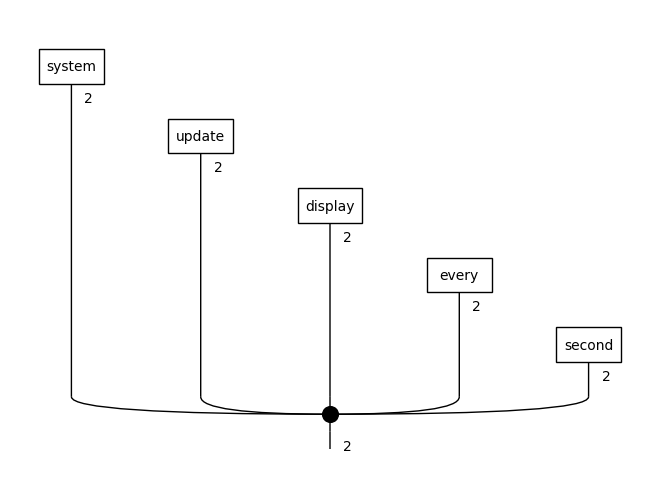

In [ ]:
networks[0].draw()

# Define evalutation metrics

In [ ]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def f1(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred, average='weighted')

eval_metrics = {'acc': accuracy,
                'f1': f1}

# Define model

In [ ]:
class ClassicalModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)

    def forward(self, input):
        x = self.get_diagram_output(input)
        x = self.fc1(x.float())
        return x

# Training

Processing Fold 1 ...


Epoch 25:  train/loss: 0.1144   valid/loss: 0.6367   train/acc: 0.8931   train/f1: 0.8912   valid/acc: 0.6944   valid/f1: 0.6860
Epoch 50:  train/loss: 0.0044   valid/loss: 1.5741   train/acc: 0.9874   train/f1: 0.9873   valid/acc: 0.6944   valid/f1: 0.6898
Epoch 75:  train/loss: 0.0213   valid/loss: 1.2921   train/acc: 0.9874   train/f1: 0.9873   valid/acc: 0.6944   valid/f1: 0.7016

Training completed!


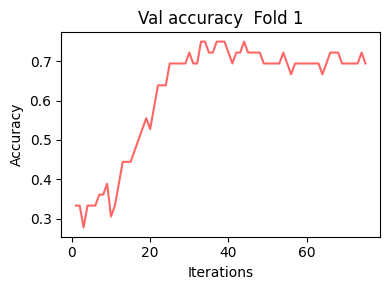

Processing Fold 2 ...


Epoch 25:  train/loss: 0.1028   valid/loss: 2.1794   train/acc: 0.8491   train/f1: 0.8472   valid/acc: 0.5278   valid/f1: 0.5219
Epoch 50:  train/loss: 0.0040   valid/loss: 4.3146   train/acc: 0.9937   train/f1: 0.9937   valid/acc: 0.5278   valid/f1: 0.5269
Epoch 75:  train/loss: 0.0006   valid/loss: 4.2512   train/acc: 0.9969   train/f1: 0.9969   valid/acc: 0.5833   valid/f1: 0.5796

Training completed!


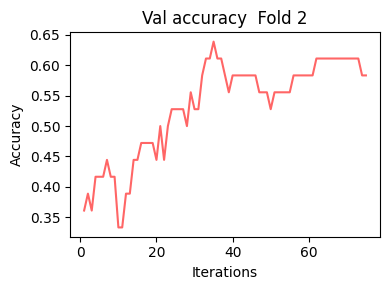

Processing Fold 3 ...


Epoch 25:  train/loss: 0.0993   valid/loss: 0.7889   train/acc: 0.8836   train/f1: 0.8847   valid/acc: 0.5833   valid/f1: 0.5870
Epoch 50:  train/loss: 0.0195   valid/loss: 1.2310   train/acc: 0.9874   train/f1: 0.9875   valid/acc: 0.5833   valid/f1: 0.5863
Epoch 75:  train/loss: 0.0007   valid/loss: 1.7143   train/acc: 0.9969   train/f1: 0.9968   valid/acc: 0.6111   valid/f1: 0.6062

Training completed!


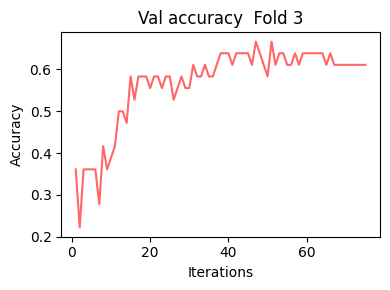

Processing Fold 4 ...


Epoch 25:  train/loss: 0.1591   valid/loss: 1.6562   train/acc: 0.8679   train/f1: 0.8667   valid/acc: 0.5278   valid/f1: 0.5210
Epoch 50:  train/loss: 0.0692   valid/loss: 2.9124   train/acc: 0.9654   train/f1: 0.9662   valid/acc: 0.5556   valid/f1: 0.5346
Epoch 75:  train/loss: 0.0361   valid/loss: 3.4789   train/acc: 0.9748   train/f1: 0.9748   valid/acc: 0.5833   valid/f1: 0.5784

Training completed!


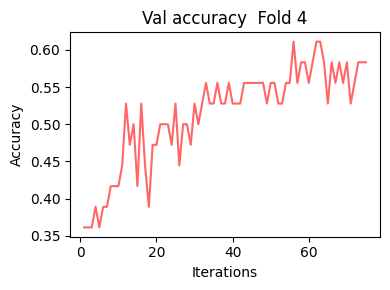

Processing Fold 5 ...


Epoch 25:  train/loss: 0.0887   valid/loss: 1.0195   train/acc: 0.8997   train/f1: 0.9011   valid/acc: 0.4571   valid/f1: 0.4555
Epoch 50:  train/loss: 0.0068   valid/loss: 1.4905   train/acc: 0.9969   train/f1: 0.9969   valid/acc: 0.6000   valid/f1: 0.6079
Epoch 75:  train/loss: 0.0118   valid/loss: 1.7143   train/acc: 0.9937   train/f1: 0.9937   valid/acc: 0.5714   valid/f1: 0.5975

Training completed!


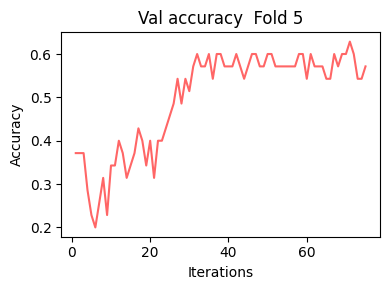

Processing Fold 6 ...


Epoch 25:  train/loss: 0.1054   valid/loss: 1.3118   train/acc: 0.8966   train/f1: 0.8974   valid/acc: 0.5429   valid/f1: 0.5442
Epoch 50:  train/loss: 0.0122   valid/loss: 3.1929   train/acc: 0.9937   train/f1: 0.9937   valid/acc: 0.5143   valid/f1: 0.5079
Epoch 75:  train/loss: 0.0003   valid/loss: 3.2163   train/acc: 0.9969   train/f1: 0.9968   valid/acc: 0.5429   valid/f1: 0.5370

Training completed!


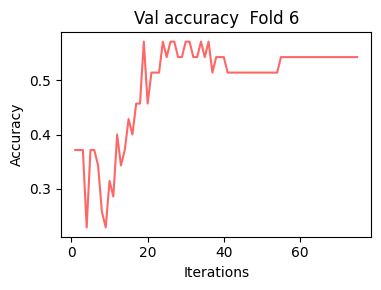

Processing Fold 7 ...


Epoch 25:  train/loss: 0.1382   valid/loss: 1.5787   train/acc: 0.7994   train/f1: 0.7858   valid/acc: 0.3714   valid/f1: 0.3381
Epoch 50:  train/loss: 0.0234   valid/loss: 2.7016   train/acc: 0.9906   train/f1: 0.9907   valid/acc: 0.6000   valid/f1: 0.5723
Epoch 75:  train/loss: 0.0006   valid/loss: 3.6879   train/acc: 1.0000   train/f1: 1.0000   valid/acc: 0.6000   valid/f1: 0.5638

Training completed!


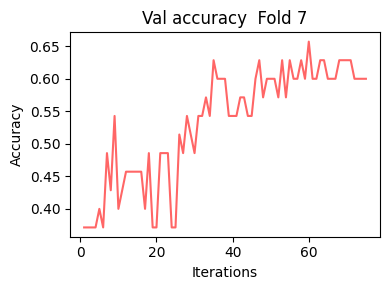

Processing Fold 8 ...


Epoch 25:  train/loss: 0.1556   valid/loss: 0.9533   train/acc: 0.8433   train/f1: 0.8248   valid/acc: 0.6571   valid/f1: 0.6472
Epoch 50:  train/loss: 0.0251   valid/loss: 1.9311   train/acc: 0.9843   train/f1: 0.9843   valid/acc: 0.6000   valid/f1: 0.6058
Epoch 75:  train/loss: 0.0632   valid/loss: 1.9372   train/acc: 0.9843   train/f1: 0.9844   valid/acc: 0.6286   valid/f1: 0.6259

Training completed!


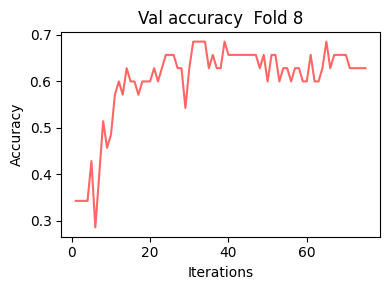

Processing Fold 9 ...


Epoch 25:  train/loss: 0.0877   valid/loss: 1.5674   train/acc: 0.9028   train/f1: 0.9053   valid/acc: 0.6000   valid/f1: 0.5847
Epoch 50:  train/loss: 0.0024   valid/loss: 3.0247   train/acc: 0.9969   train/f1: 0.9969   valid/acc: 0.6571   valid/f1: 0.6356
Epoch 75:  train/loss: 0.0001   valid/loss: 3.1323   train/acc: 1.0000   train/f1: 1.0000   valid/acc: 0.6286   valid/f1: 0.6099

Training completed!


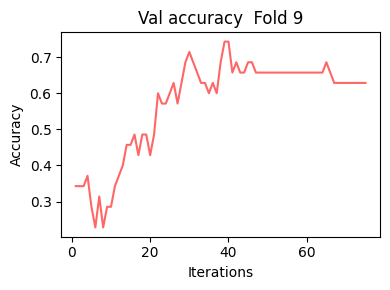

Processing Fold 10 ...


Epoch 25:  train/loss: 0.1719   valid/loss: 0.7631   train/acc: 0.8527   train/f1: 0.8572   valid/acc: 0.6857   valid/f1: 0.6773
Epoch 50:  train/loss: 0.0216   valid/loss: 1.8850   train/acc: 0.9749   train/f1: 0.9753   valid/acc: 0.6286   valid/f1: 0.6237
Epoch 75:  train/loss: 0.0005   valid/loss: 3.0347   train/acc: 1.0000   train/f1: 1.0000   valid/acc: 0.6286   valid/f1: 0.6131

Training completed!


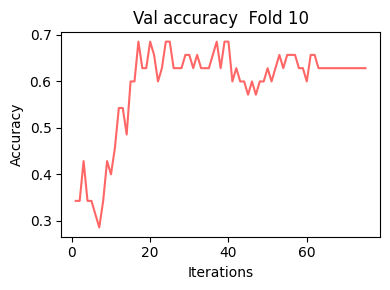

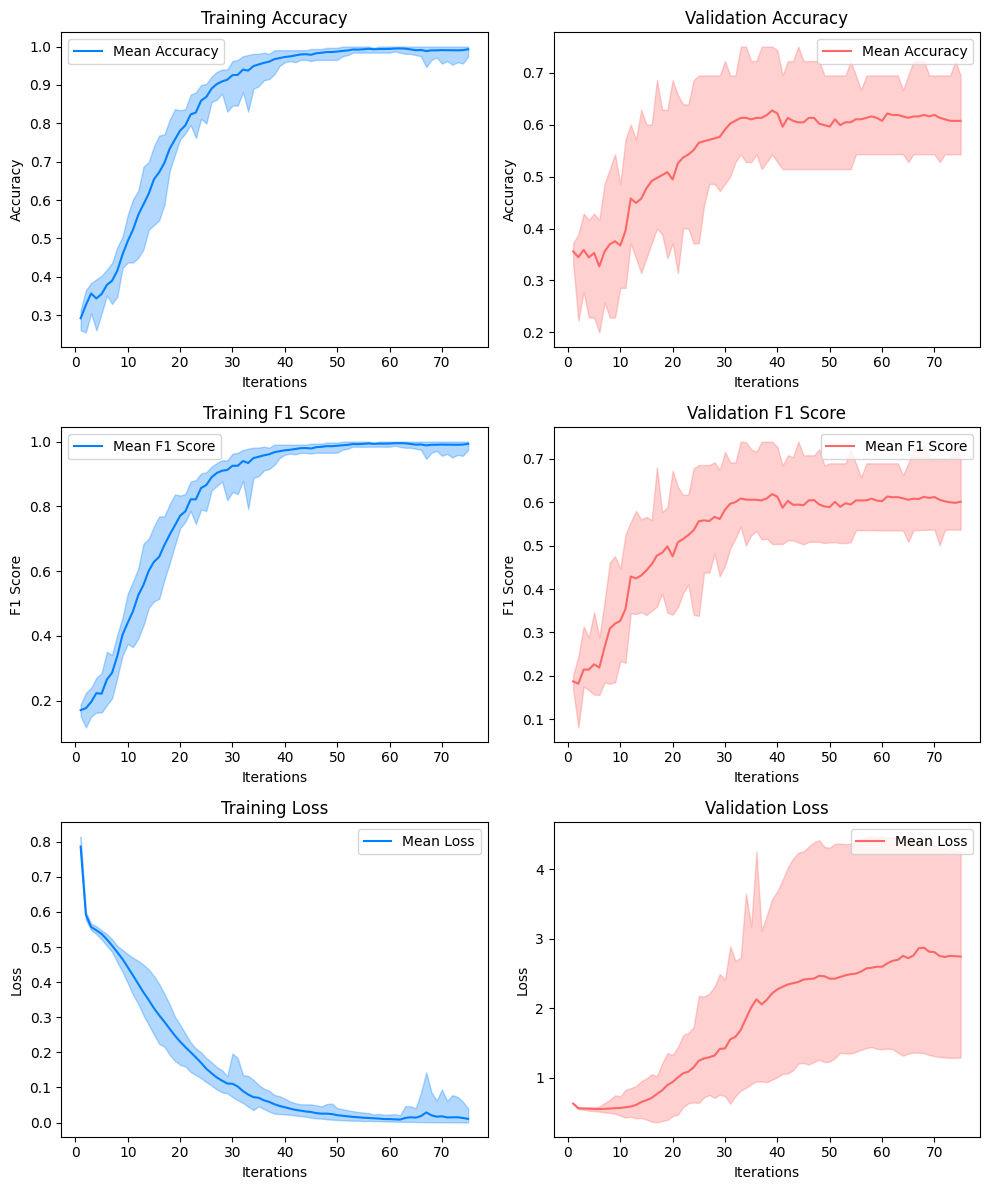

In [ ]:
EPOCHS = 75
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

# Grid search
for lr in [2e-2]:
    for bs in [64]:

        cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
        networks_np = np.array(networks, dtype=object)
        targets_np = np.array(targets, dtype=object)

        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []
        train_f1 = []
        val_f1 = []

        for i, (train_index, val_index) in enumerate(cv.split(networks_np, targets_np.argmax(1))):

            print(f'Processing Fold {i+1} ...')

            train_fold = Dataset(networks_np[train_index], targets_np[train_index], batch_size=bs)
            val_fold = Dataset(networks_np[val_index], targets_np[val_index])

            model = ClassicalModel.from_diagrams(networks)
            model.initialise_weights()

            trainer = PytorchTrainer(
                model=model,
                loss_function=torch.nn.BCEWithLogitsLoss(),
                optimizer=torch.optim.AdamW,
                learning_rate=lr,
                epochs=EPOCHS,
                evaluate_functions=eval_metrics,
                evaluate_on_train=True,
                verbose='text',
                seed=SEED
            )

            trainer.fit(train_fold, val_fold, log_interval=25, early_stopping_interval=EARLY_STOPPING)

            train_accuracies.append(trainer.train_eval_results['acc'])
            val_accuracies.append(trainer.val_eval_results['acc'])

            train_f1.append(trainer.train_eval_results['f1'])
            val_f1.append(trainer.val_eval_results['f1'])

            train_losses.append(trainer.train_epoch_costs)
            val_losses.append(trainer.val_costs)

            fig, axes = plt.subplots(1, 1, figsize=(4, 3))

            # Plot for training accuracy
            axes.set_title(f'Val accuracy  Fold {i+1}')
            axes.set_xlabel('Iterations')
            axes.set_ylabel('Accuracy')
            axes.plot(np.arange(1, len(trainer.train_epoch_costs) + 1), trainer.val_eval_results['acc'], color=custom_secondary)

            plt.tight_layout()
            plt.show()

        range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

        # Calculate mean, min, and max metrics
        mean_train_accuracy = np.mean(train_accuracies, axis=0)
        min_train_accuracy = np.min(train_accuracies, axis=0)
        max_train_accuracy = np.max(train_accuracies, axis=0)

        mean_val_accuracy = np.mean(val_accuracies, axis=0)
        min_val_accuracy = np.min(val_accuracies, axis=0)
        max_val_accuracy = np.max(val_accuracies, axis=0)

        mean_train_f1 = np.mean(train_f1, axis=0)
        min_train_f1 = np.min(train_f1, axis=0)
        max_train_f1 = np.max(train_f1, axis=0)

        mean_val_f1 = np.mean(val_f1, axis=0)
        min_val_f1 = np.min(val_f1, axis=0)
        max_val_f1 = np.max(val_f1, axis=0)

        mean_train_loss = np.mean(train_losses, axis=0)
        min_train_loss = np.min(train_losses, axis=0)
        max_train_loss = np.max(train_losses, axis=0)

        mean_val_loss = np.mean(val_losses, axis=0)
        min_val_loss = np.min(val_losses, axis=0)
        max_val_loss = np.max(val_losses, axis=0)

        fig, axes = plt.subplots(3, 2, figsize=(10, 12))

        # Plot for training accuracy
        axes[0, 0].set_title('Training Accuracy')
        axes[0, 0].set_xlabel('Iterations')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
        axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
        axes[0, 0].legend()

        # Plot for validation accuracy
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Iterations')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
        axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
        axes[0, 1].legend()

        # Plot for training F1 score
        axes[1, 0].set_title('Training F1 Score')
        axes[1, 0].set_xlabel('Iterations')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
        axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
        axes[1, 0].legend()

        # Plot for validation F1 score
        axes[1, 1].set_title('Validation F1 Score')
        axes[1, 1].set_xlabel('Iterations')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
        axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
        axes[1, 1].legend()

        # Plot for training loss
        axes[2, 0].set_title('Training Loss')
        axes[2, 0].set_xlabel('Iterations')
        axes[2, 0].set_ylabel('Loss')
        axes[2, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
        axes[2, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
        axes[2, 0].legend()

        # Plot for validation loss
        axes[2, 1].set_title('Validation Loss')
        axes[2, 1].set_xlabel('Iterations')
        axes[2, 1].set_ylabel('Loss')
        axes[2, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
        axes[2, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
        axes[2, 1].legend()

        plt.tight_layout()
        plt.show()